In [8]:
import numpy as np
import pandas as pd
#import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.models import  Model
from sklearn.utils import resample
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from google.colab import drive
import time

np.random.seed(100)

In [3]:
train_dir = 'E:/dataset/FER2013+CK/train/'
val_dir = 'E:/dataset/FER2013/val/'

BS = 64
PATIENCE =10

IMAGE_SIZE = (96,96)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
print(IMAGE_SHAPE)

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

(96, 96, 3)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    zoom_range=0.3,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=False
                                    
                                    )

val_datagen  = ImageDataGenerator(rescale = 1./255
                                   
                                  )

In [12]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)
#test_dir = 'N:/내 드라이브/DataSet/FER2013/test/'
val_dataset = val_datagen.flow_from_directory(directory = val_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)

Found 29611 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [13]:
from IPython.display import Image, HTML
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
val_count = count_exp(val_dir, 'val')

HTML(train_count.append(val_count).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,4040,495,4122,7284,5558,4858,3254
val,467,56,496,895,607,653,415


In [14]:
# Data labels

class_labels = val_dataset.class_indices
class_labels

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

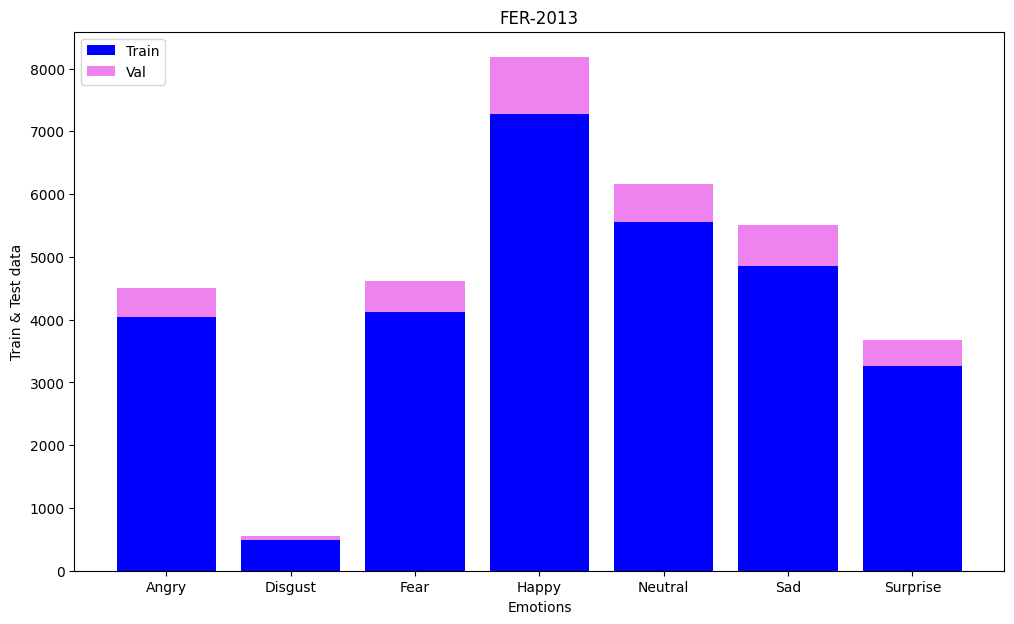

In [15]:
# # lot distribution of train/test dataste per class

x = list(val_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = val_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Val"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

In [16]:
from collections import Counter
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  
class_weights

{0: 1.8, 1: 14.72, 2: 1.77, 3: 1.0, 4: 1.31, 5: 1.5, 6: 2.24}

In [9]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

base_model = tf.keras.applications.xception.Xception(input_shape=IMAGE_SHAPE, include_top=False, weights="imagenet")
base_model.summary()



Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 12, 12, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 12, 12, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_10 (Conv2D)             (None, 6, 6, 728)    186368      ['add_25[0][0]']                 
                                                                                                  
 block4_pool (MaxPooling2D)     (None, 6, 6, 728)    0           ['block4_sepconv2_bn[0][0]']     
          

 block7_sepconv1_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 6, 6, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 6, 6, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv2_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv2[0][0]']        
 lization)

                                                                                                  
 block10_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_31[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 6, 6, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
                                                                                                  
 block10_s

 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_34 (Add)                   (None, 6, 6, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_33[0][0]']                 
                                                                                                  
 block13_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_34[0][0]']                 
 on)                                                                                              
          

In [10]:
for layer in base_model.layers:
    layer.trainable=True

In [11]:
model = models.Sequential()
model.add(base_model)
#model.add(layers.Conv2D(1280, (1, 1), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 2048)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# 생성된 이미지 파일 보기
img = plt.imread('model.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: [Errno 2] No such file or directory: 'model.png'

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [21]:
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score
]

model.compile(
    optimizer=Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']#, f1_score]
     #metrics=METRICS        
)

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(train_dataset, validation_data=val_dataset,  
                      callbacks=callbackFunction('2-2_X'),
                      batch_size=BS,  
                      epochs = 30, 
                      verbose=1,
                      class_weight = class_weights
                      )

Epoch 1/30
463/463 [==============================] - ETA: 0s - loss: 3.3658 - accuracy: 0.1813
Epoch 1: val_accuracy improved from -inf to 0.20424, saving model to Checkpoints\2-2_X.h5
463/463 [==============================] - 126s 258ms/step - loss: 3.3658 - accuracy: 0.1813 - val_loss: 1.9058 - val_accuracy: 0.2042
Epoch 2/30
463/463 [==============================] - ETA: 0s - loss: 3.2062 - accuracy: 0.2491
Epoch 2: val_accuracy improved from 0.20424 to 0.36361, saving model to Checkpoints\2-2_X.h5
463/463 [==============================] - 61s 131ms/step - loss: 3.2062 - accuracy: 0.2491 - val_loss: 1.6830 - val_accuracy: 0.3636
Epoch 3/30
463/463 [==============================] - ETA: 0s - loss: 3.0477 - accuracy: 0.3026
Epoch 3: val_accuracy improved from 0.36361 to 0.39816, saving model to Checkpoints\2-2_X.h5
463/463 [==============================] - 61s 131ms/step - loss: 3.0477 - accuracy: 0.3026 - val_loss: 1.6006 - val_accuracy: 0.3982
Epoch 4/30
463/463 [=============

Epoch 27/30
463/463 [==============================] - ETA: 0s - loss: 1.8308 - accuracy: 0.5726
Epoch 27: val_accuracy did not improve from 0.58902
463/463 [==============================] - 61s 131ms/step - loss: 1.8308 - accuracy: 0.5726 - val_loss: 1.0898 - val_accuracy: 0.5879
Epoch 28/30
463/463 [==============================] - ETA: 0s - loss: 1.8153 - accuracy: 0.5750
Epoch 28: val_accuracy improved from 0.58902 to 0.59404, saving model to Checkpoints\2-2_X.h5
463/463 [==============================] - 60s 130ms/step - loss: 1.8153 - accuracy: 0.5750 - val_loss: 1.0874 - val_accuracy: 0.5940
Epoch 29/30
463/463 [==============================] - ETA: 0s - loss: 1.7922 - accuracy: 0.5800
Epoch 29: val_accuracy improved from 0.59404 to 0.60435, saving model to Checkpoints\2-2_X.h5
463/463 [==============================] - 60s 129ms/step - loss: 1.7922 - accuracy: 0.5800 - val_loss: 1.0710 - val_accuracy: 0.6043
Epoch 30/30
463/463 [==============================] - ETA: 0s - lo

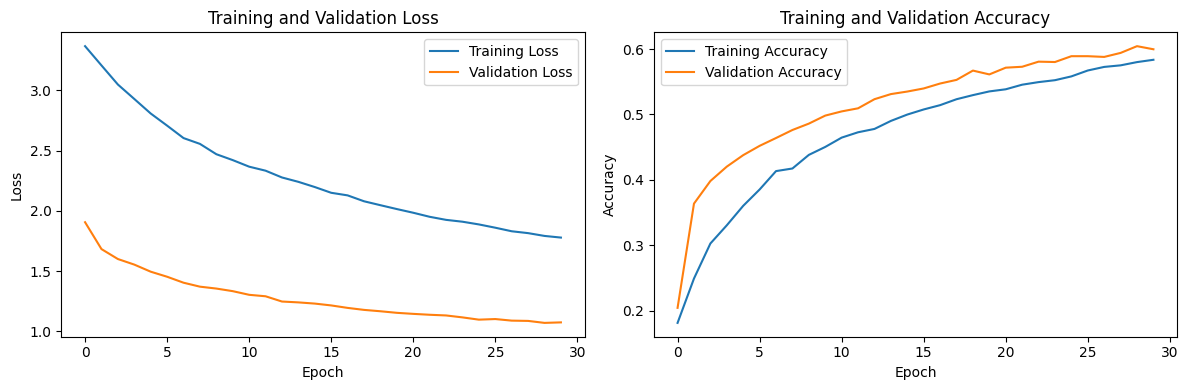

In [23]:
import matplotlib.pyplot as plt

# Extract training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
model.save('new_2-2_X.h5')

In [24]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
val_evaluation = model.evaluate(val_dataset)
#test_evaluation2 = model.evaluate(test_dataset2)

57/57 [==============================] - 2s 30ms/step - loss: 1.0752 - accuracy: 0.5996


In [25]:
metric_list = ["Loss","Accuracy", "Precision", "F1_Score", "Recall", "Auc"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in val_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate
0,Loss,1.054,1.075
1,Accuracy,0.605,0.600


In [26]:
test_dir = 'E:/dataset/Only_Kor_Test/'
test_datagen  = ImageDataGenerator(rescale = 1./255)
test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)
jaffe_dir = 'E:/dataset/jaffedbase/'
jaffe_datagen  = ImageDataGenerator(rescale = 1./255)
jaffe_dataset = test_datagen.flow_from_directory(directory = jaffe_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)

Found 758 images belonging to 7 classes.
Found 213 images belonging to 7 classes.


In [27]:
test_evaluation = model.evaluate(test_dataset)
jaffe_evaluation = model.evaluate(jaffe_dataset)

4/4 [==============================] - 0s 143ms/step - loss: 2.2292 - accuracy: 0.2629


In [28]:
metric_list = ["Loss","Accuracy", "Precision", "F1_Score", "Recall", "Auc"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in val_evaluation],
                           [round(num, 3) for num in test_evaluation],
                           [round(num, 3) for num in jaffe_evaluation],
                          )),
                  columns=['Metric Name', 'Train', 'Validate', 'KFE', 'JAFFE'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate,KFE,JAFFE
0,Loss,1.054,1.075,2.715,2.229
1,Accuracy,0.605,0.600,0.270,0.263
